#  Proyecto <a class="tocSkip">


## Importación de Datos

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import sklearn.tree as tree
from sklearn import metrics
import seaborn as sns

df = pd.read_csv("heart_failure_clinical_records_dataset.csv")
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [ ]:

y = df.DEATH_EVENT
X = df[df.columns[:-1]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) 
obtimes_train = X_train["time"]
obtimes_test = X_test["time"]
X_train = X_train[df.columns[:-2]]
X_test = X_test[df.columns[:-2]]

## Entrenamiento de RandomForest

In [ ]:
# Entrenamiento y generación
clf=RandomForestClassifier(n_estimators=3000,bootstrap = False,
                          min_samples_leaf = 0.04,max_features = 0.5,n_jobs = 2)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)

In [ ]:

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.6444444444444445


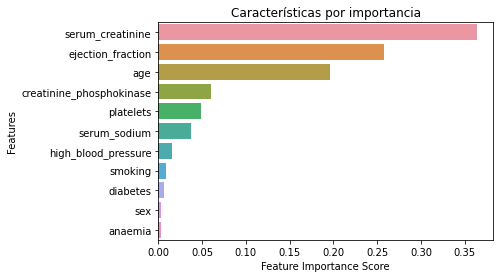

In [ ]:

feature_imp = pd.Series(clf.feature_importances_,index=X.columns[:-1]).sort_values(ascending=False)
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Características por importancia")

RFGraph = plt.show()

## Árboles de Decisión en el RF (DecisionTree)

### Exactitud de los árboles en el bosque

In [ ]:
estimators = clf.estimators_
trees = [e.tree_ for e in estimators]


In [ ]:
def tree_acc(estimator, xe = X_test, ye= y_test):
    y_prede = estimator.predict(xe)
    acc = metrics.accuracy_score(ye, y_prede)
    return acc

def tree_rec(estimator, xe = X_test, ye= y_test):
    y_prede = estimator.predict(xe)
    rec = metrics.recall_score(ye, y_prede)
    return rec

def tree_cf(estimator, xe = X_test, ye= y_test):
    metrics.ConfusionMatrixDisplay.from_estimator(estimator, xe, ye)


Se truncaron las últimas líneas 5000 del resultado de transmisión.
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/py

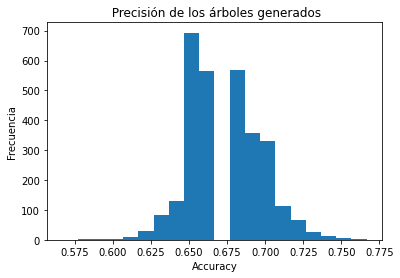

In [ ]:
accs = [tree_acc(e) for e in estimators]
plt.hist(accs,bins =20)
plt.title(" Precisión de los árboles generados")
plt.xlabel("Accuracy")
plt.ylabel("Frecuencia")
plt.show()

### Árbol más exacto

In [ ]:
most_acc = np.argmax(accs)

most_acc = estimators[most_acc]


Mostramos una gŕafica del árbol más preciso generado. En cada nodo se muestra el criterio utilizado en cada paso.

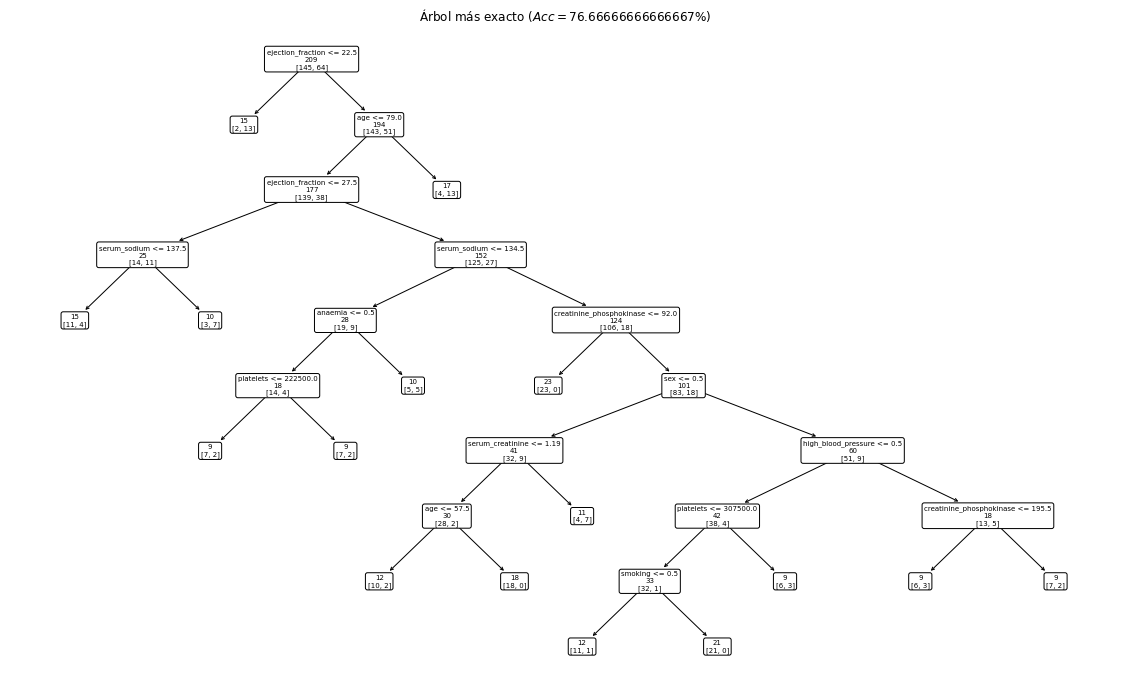

In [ ]:

plt.rcParams['figure.figsize'] = [20, 12]
tree.plot_tree(most_acc,label = 'none',fontsize = 7,rounded = True
               ,impurity = False, feature_names = X_train.columns)
plt.title(f"Árbol más exacto ($Acc = {max(accs)*100}$%)")
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


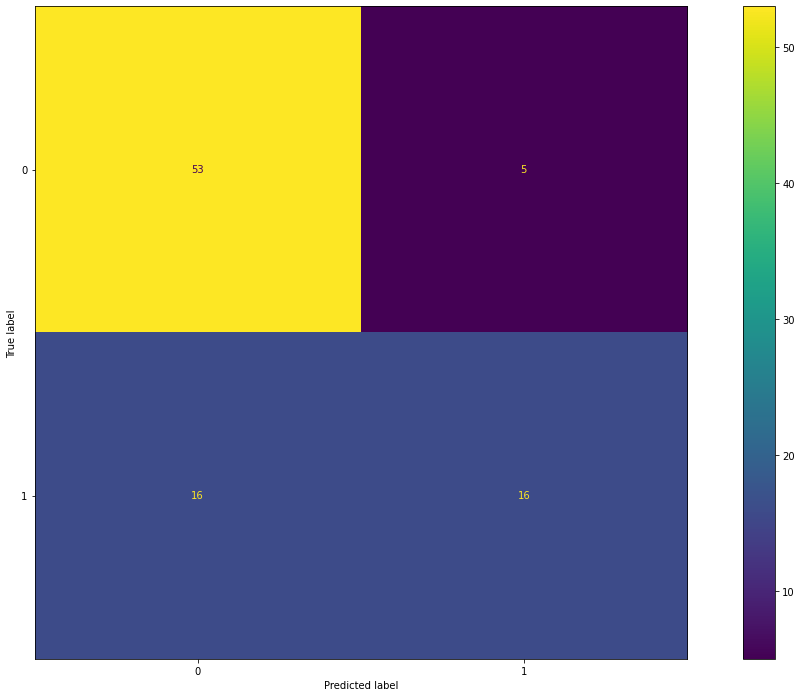

In [ ]:
cm = tree_cf(most_acc)

## Caminos de decisión

Mostramos el camino que se sigue para evaluar una muestra particular.

In [ ]:
xt = np.array(X_train.to_numpy())
feature = most_acc.tree_.feature
threshold = most_acc.tree_.threshold


node_indicator = most_acc.decision_path(xt)
sample_id = 10
leaf_id = most_acc.apply(xt)
# -------------------

# obtain ids of the nodes `sample_id` goes through, i.e., row `sample_id`
node_index = node_indicator.indices[
    node_indicator.indptr[sample_id] : node_indicator.indptr[sample_id + 1]
]
# -------------------

for node_id in node_index:
    # fin de la decisión
    if leaf_id[sample_id] == node_id:
        s = "El paciente probablemente sobreviva" if (most_acc.predict(xt[sample_id:sample_id+1]))[0]==0. else "El paciente probablemente muera"
        print(s)
        continue

    # verificar la rama que sigue
    if xt[sample_id, feature[node_id]] <= threshold[node_id]:
        threshold_sign = "<="
    else:
        threshold_sign = ">"

    print(
        "decision node {node} : {feature} = {value} "
        "{inequality} {threshold})".format(
            node=node_id,
            feature=df.columns[feature[node_id]],
            value=xt[sample_id, feature[node_id]],
            inequality=threshold_sign,
            threshold=threshold[node_id],
        )
    )

decision node 0 : ejection_fraction = 35.0 > 22.5)
decision node 2 : age = 85.0 > 79.0)
El paciente probablemente muera


## Evaluación de tiempo de decisión

In [ ]:
time_dicc = {"age":0, "anaemia": 24,	"creatinine_phosphokinase":36,	"diabetes":36,	"ejection_fraction":36,	"high_blood_pressure":48,	"platelets":24,	"serum_creatinine":24,	"serum_sodium":24, "sex":0,	"smoking":0,	"time":0,	"DEATH_EVENT":0}

# reemplazar con datos reales
for f in df.columns:
    time_dicc[f]  = time_dicc[f]

def time_required(est,sample ):
    s = []
    features = est.tree_.feature

    node_indicator = est.decision_path(sample)
    for sample_id in range(len(sample)):
        time_req = 0
        features_req = set()
        leaf_id = est.apply(xt)
        # -------------------

        # obtain ids of the nodes `sample_id` goes through, i.e., row `sample_id`
        node_index = node_indicator.indices[
            node_indicator.indptr[sample_id] : node_indicator.indptr[sample_id + 1]
        ]
        # -------------------
        
        # Recorre el camino de decisión
        for node_id in node_index:
            # fin de la decisión
            if leaf_id[sample_id] == node_id:
                continue
            
            feature=df.columns[features[node_id]]
            features_req.add(feature)
        # máximo de los tiempos de las caracteristicas usadas
        time_req = max([time_dicc[f] for f in features_req])
        
        s.append(time_req)
    
    return np.array(s)


In [ ]:
def mean_time_required(est,sample):
    return np.mean(time_required(est,sample ))
times = np.array([mean_time_required(e,X_test) for e in estimators])


Se truncaron las últimas líneas 5000 del resultado de transmisión.
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/py

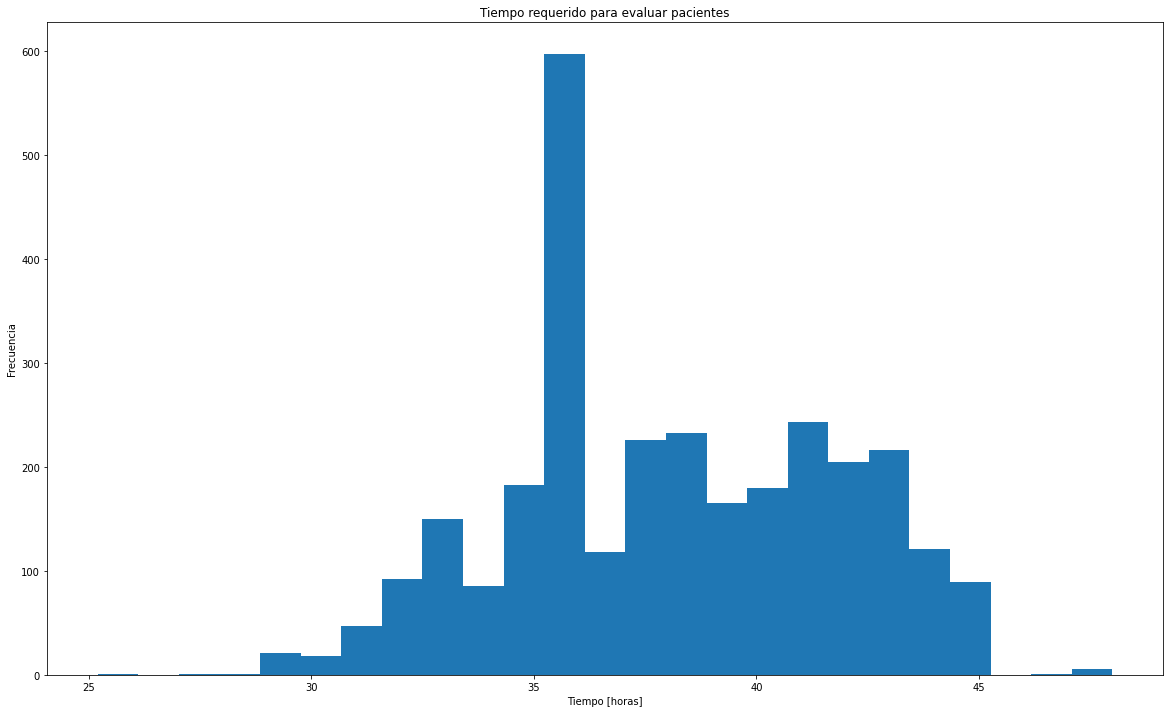

In [ ]:


plt.hist(times,bins = 25)
plt.title("Tiempo requerido para evaluar pacientes")
plt.xlabel("Tiempo [horas]")
plt.ylabel("Frecuencia")
plt.show()

Text(0.5, 1.0, ' Precisión contra tiempo promedio de decisión de los árboles')

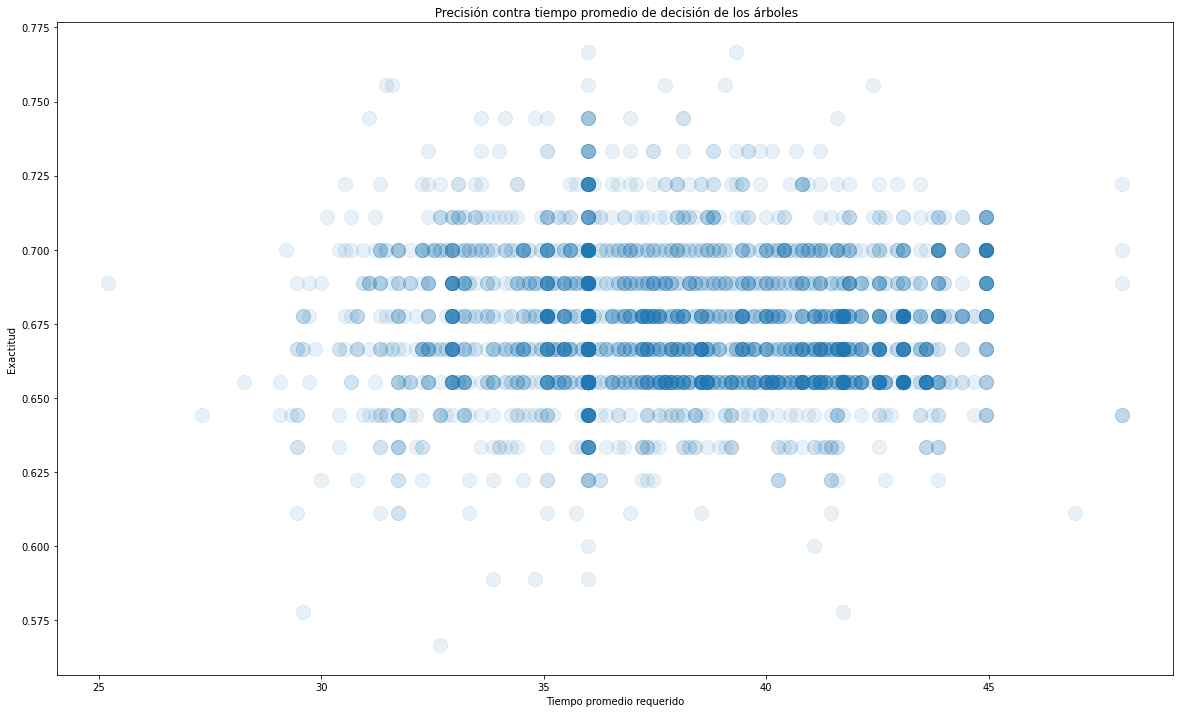

In [ ]:
plt.scatter(times,accs,alpha = 0.1,s = 200)
plt.xlabel("Tiempo promedio requerido")
plt.ylabel("Exactitud")
plt.title(" Precisión contra tiempo promedio de decisión de los árboles")

In [ ]:
np.corrcoef(times,accs)

array([[ 1.        , -0.02509297],
       [-0.02509297,  1.        ]])

## Árbol mas rápido

In [ ]:
fastest = np.argmin(times)

fastest = estimators[fastest]

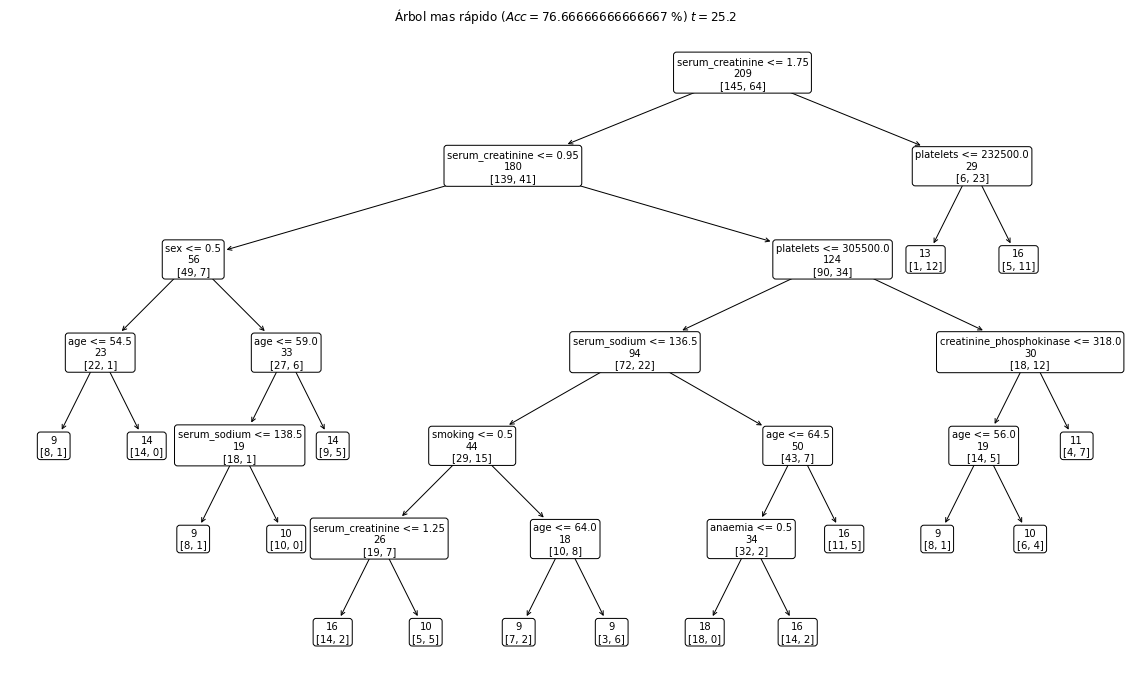

In [ ]:

tree.plot_tree(fastest,label = 'none',fontsize = 10,rounded = True
               ,impurity = False, feature_names = X_train.columns)
plt.title(f"Árbol mas rápido ($Acc = {max(accs)*100}$ %) $t = {min(times)}$")
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


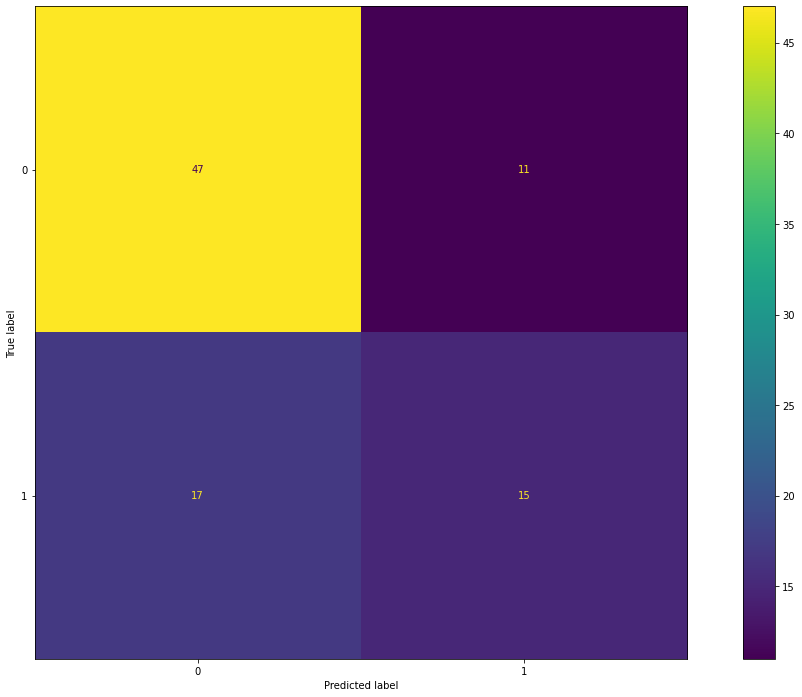

In [ ]:
cm = tree_cf(fastest)

## Árbol más Exhaustivo

In [ ]:
recs = [tree_rec(e) for e in estimators]
most_rec = np.argmax(recs)

most_rec = estimators[most_rec]

Se truncaron las últimas líneas 5000 del resultado de transmisión.
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/py

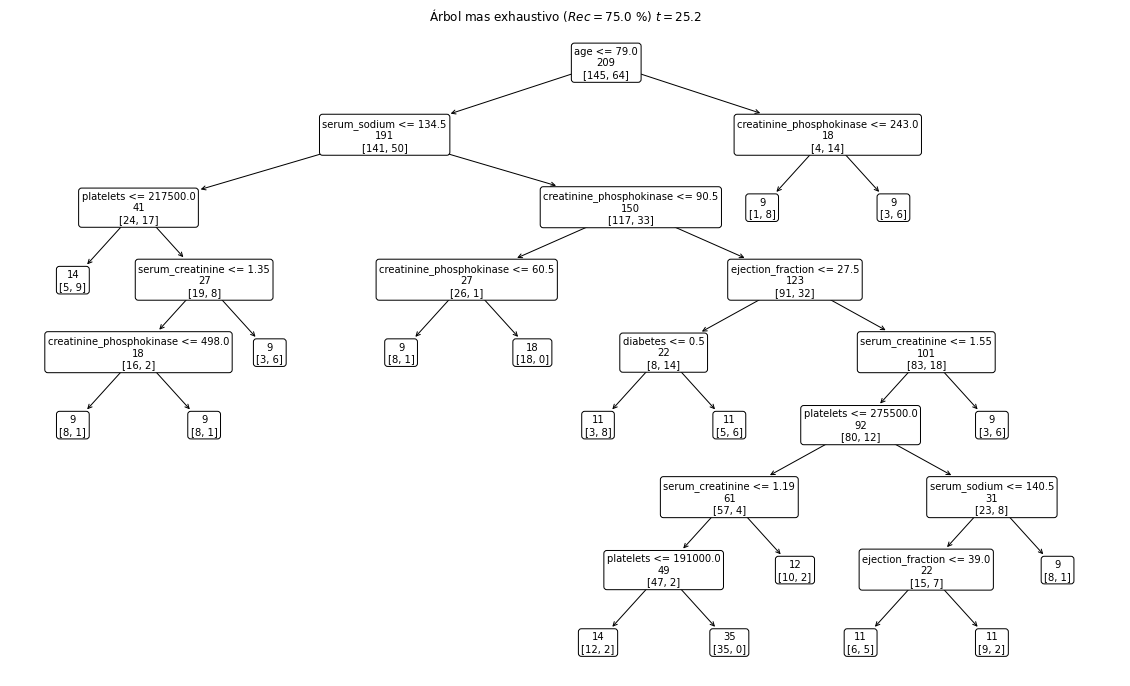

In [ ]:
tree.plot_tree(most_rec,label = 'none',fontsize = 10,rounded = True
               ,impurity = False, feature_names = X_train.columns)
plt.title(f"Árbol mas exhaustivo ($Rec = {max(recs)*100}$ %) $t = {min(times)}$")
plt.show()

Text(0.5, 1.0, 'Exhaustividad contra tiempo promedio de decisión de los árboles')

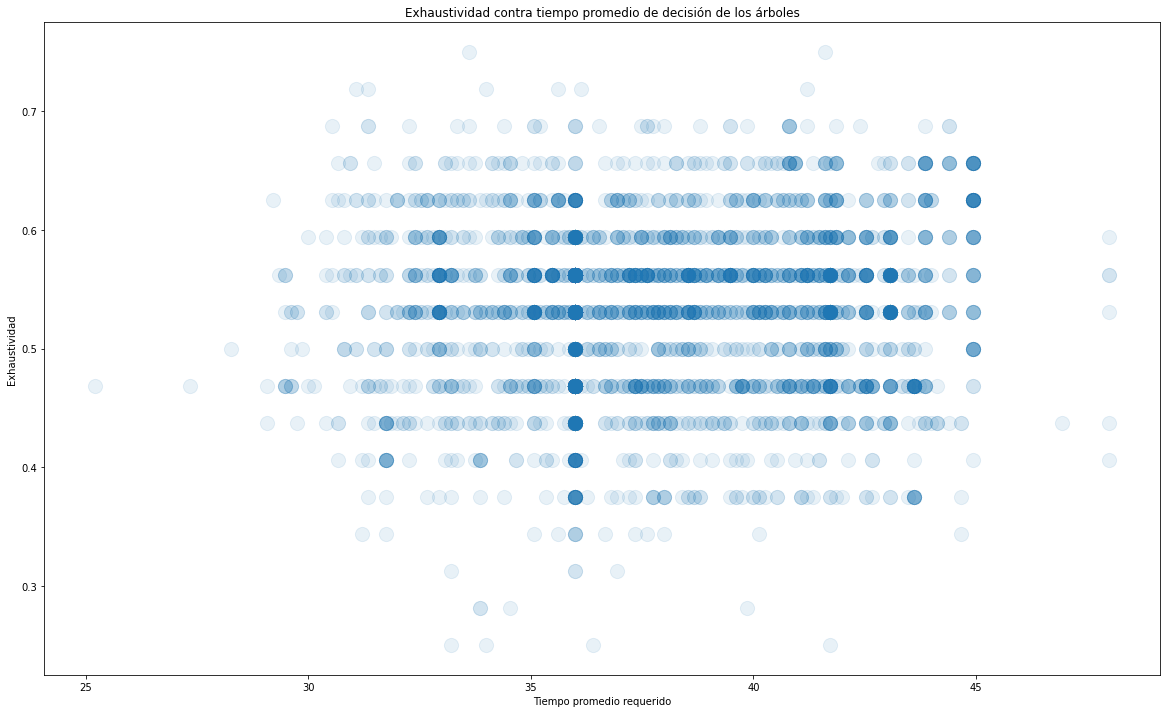

In [ ]:
plt.scatter(times,recs,alpha = 0.1,s = 200)
plt.xlabel("Tiempo promedio requerido")
plt.ylabel("Exhaustividad")
plt.title("Exhaustividad contra tiempo promedio de decisión de los árboles")

In [ ]:
np.corrcoef(times,recs)

array([[1.        , 0.06371889],
       [0.06371889, 1.        ]])

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


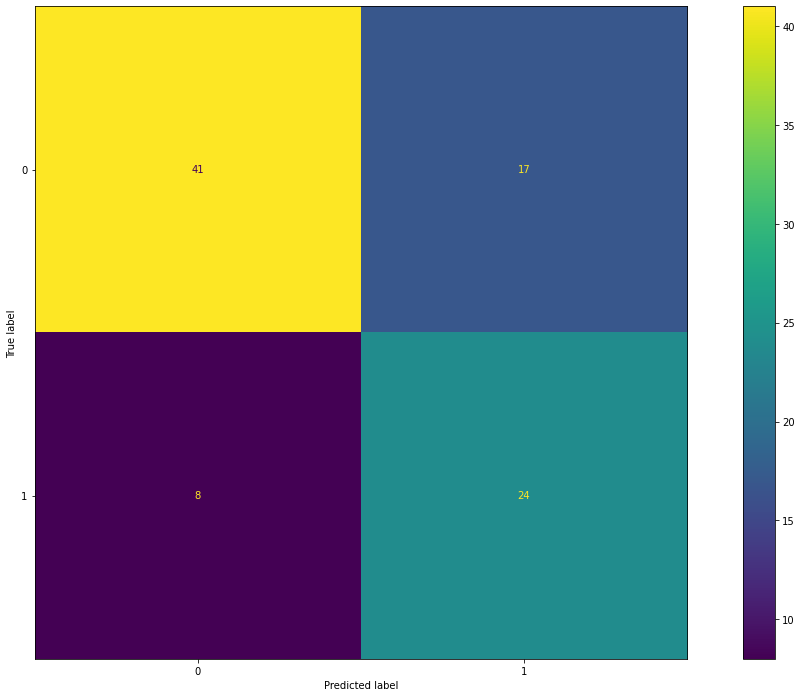

In [ ]:
cm = tree_cf(most_rec)

Text(0.5, 1.0, 'Exhaustividad contra exactitud de los árboles')

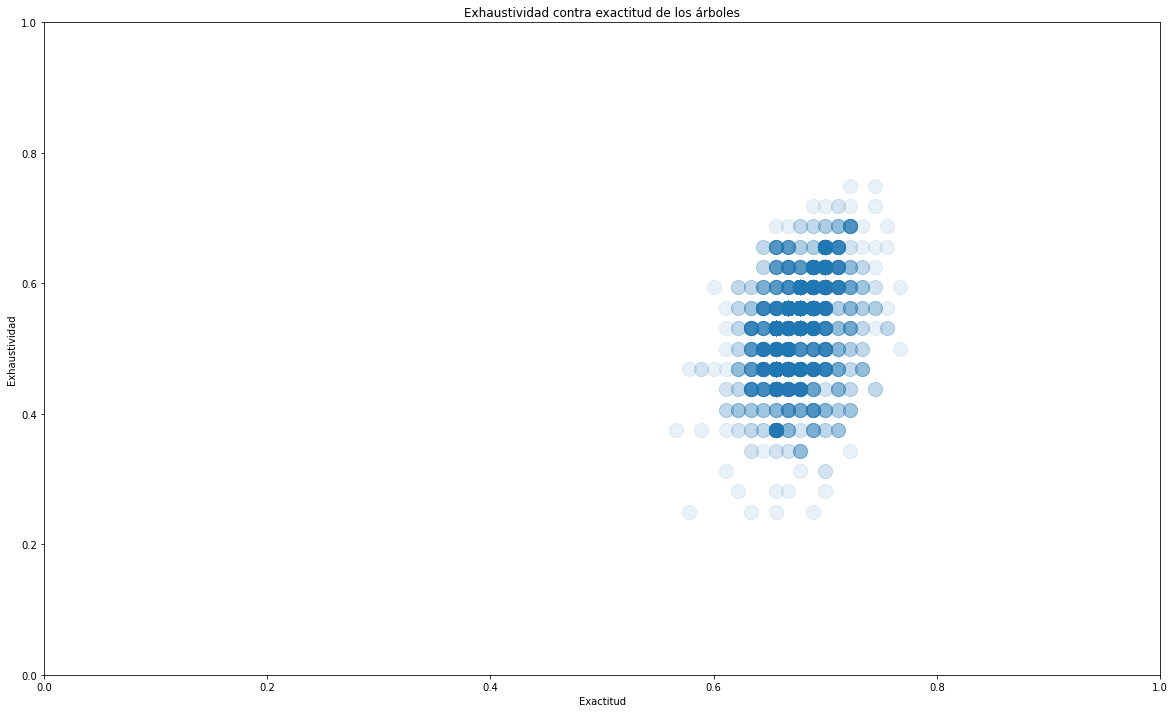

In [ ]:
plt.scatter(accs,recs,alpha = 0.1,s = 200)
plt.xlabel("Exactitud")
plt.ylabel("Exhaustividad")
plt.xlim([0,1])
plt.ylim([0,1])
plt.title("Exhaustividad contra exactitud de los árboles")

## Frácción útil de tiempo

In [ ]:
def tree_utf(estimator, xe = X_test, ye= y_test,ot = obtimes_test):
    deceased = ye == 1
    xs = xe[deceased]
    ys = ye[deceased]
    ot = ot[deceased]
    y_prede = estimator.predict(xs)
    correct = ys == y_prede
    treq = (1-time_required(estimator,xs)/(24*ot))[correct]
    s = np.sum(treq)/len(ys)
    return s
    

In [ ]:
print(f"UTF del árbol mas rápido {tree_utf(fastest)}")
print(f"UTF del árbol mas exacto {tree_utf(most_acc)}")
print(f"UTF del árbol mas exhaustivo {tree_utf(most_rec)}")



UTF del árbol mas rápido 0.44505095297244995
UTF del árbol mas exacto 0.4518985164470831
UTF del árbol mas exhaustivo 0.7059020157260547


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has featu

In [ ]:
utfs = [tree_utf(e) for e in estimators]

Se truncaron las últimas líneas 5000 del resultado de transmisión.
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/py

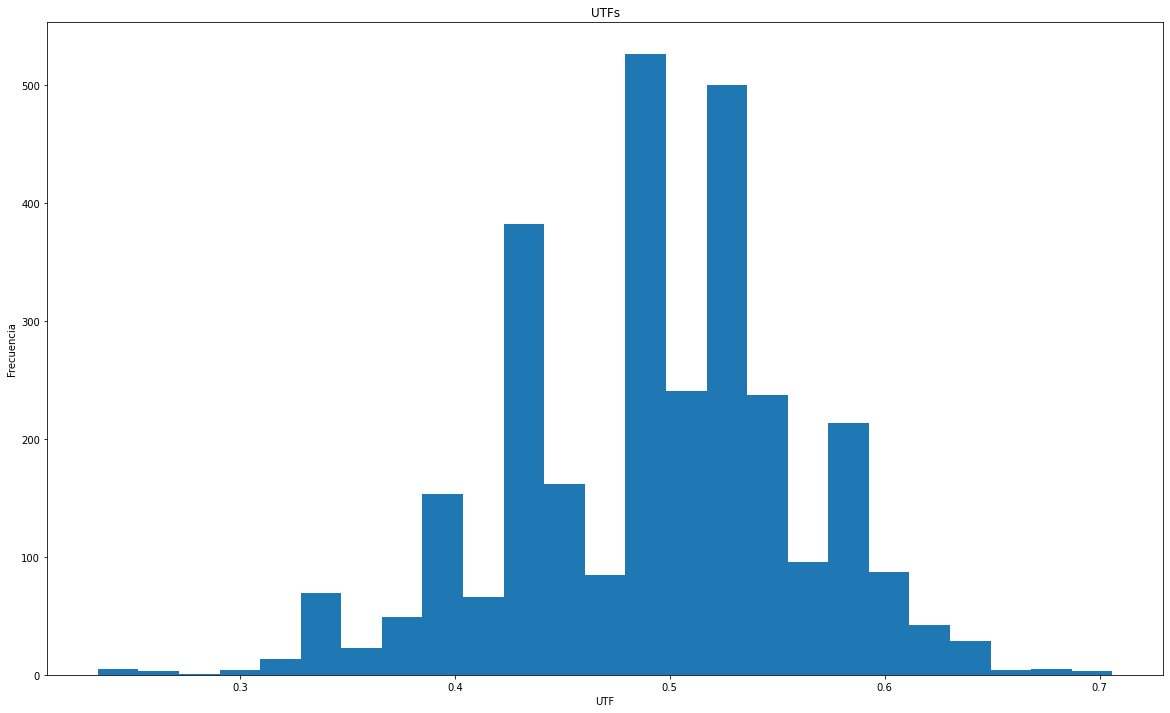

In [ ]:
plt.hist(utfs,bins = 25)
plt.title("UTFs")
plt.xlabel("UTF")
plt.ylabel("Frecuencia")
plt.show()

Text(0.5, 1.0, ' UTF contra tiempo promedio de decisión de los árboles')

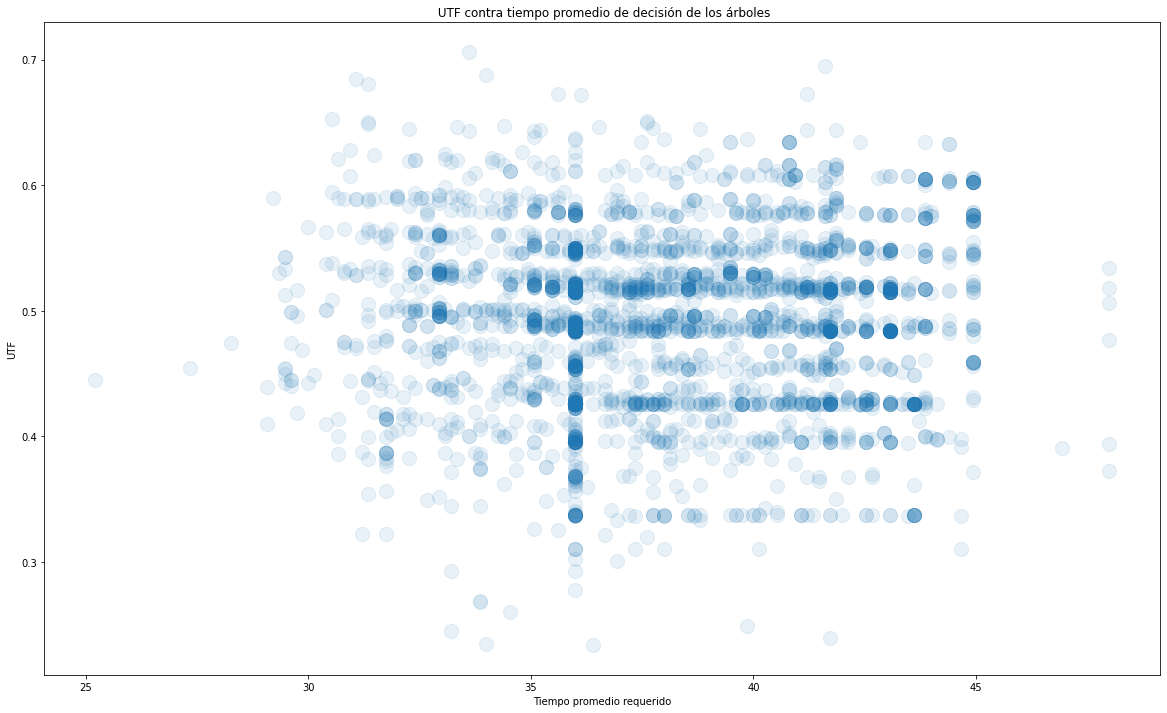

In [ ]:
plt.scatter(times,utfs,alpha = 0.1,s = 200)
plt.xlabel("Tiempo promedio requerido")
plt.ylabel("UTF")
plt.title(" UTF contra tiempo promedio de decisión de los árboles")

In [ ]:
np.corrcoef(times,utfs)

array([[1.        , 0.01425839],
       [0.01425839, 1.        ]])

In [ ]:
np.corrcoef(recs,utfs)

array([[1.        , 0.99525609],
       [0.99525609, 1.        ]])

Text(0.5, 1.0, ' UTF contra exhaustividad de los árboles')

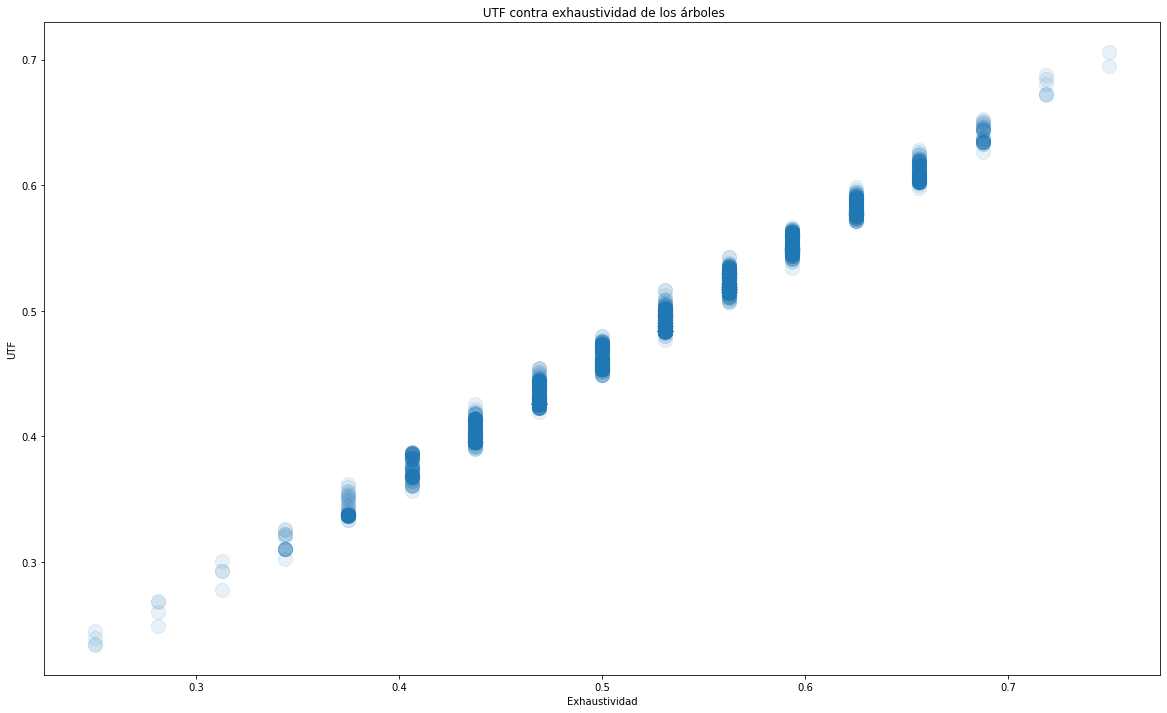

In [ ]:
plt.scatter(recs,utfs,alpha = 0.1,s = 200)
plt.xlabel("Exhaustividad")
plt.ylabel("UTF")
plt.title(" UTF contra exhaustividad de los árboles")

In [ ]:
most_utf = np.argmax(utfs)
most_utf = estimators[most_utf]

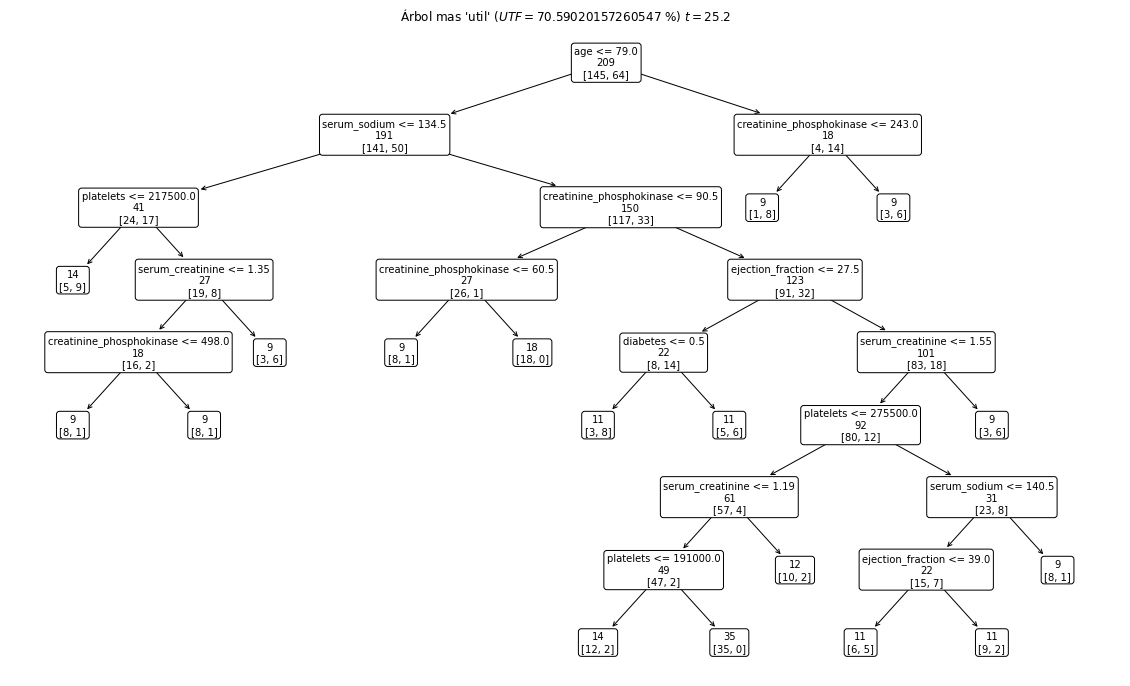

In [ ]:
tree.plot_tree(most_utf,label = 'none',fontsize = 10,rounded = True
               ,impurity = False, feature_names = X_train.columns)
plt.title(f"Árbol mas 'util' ($UTF = {max(utfs)*100}$ %) $t = {min(times)}$")
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


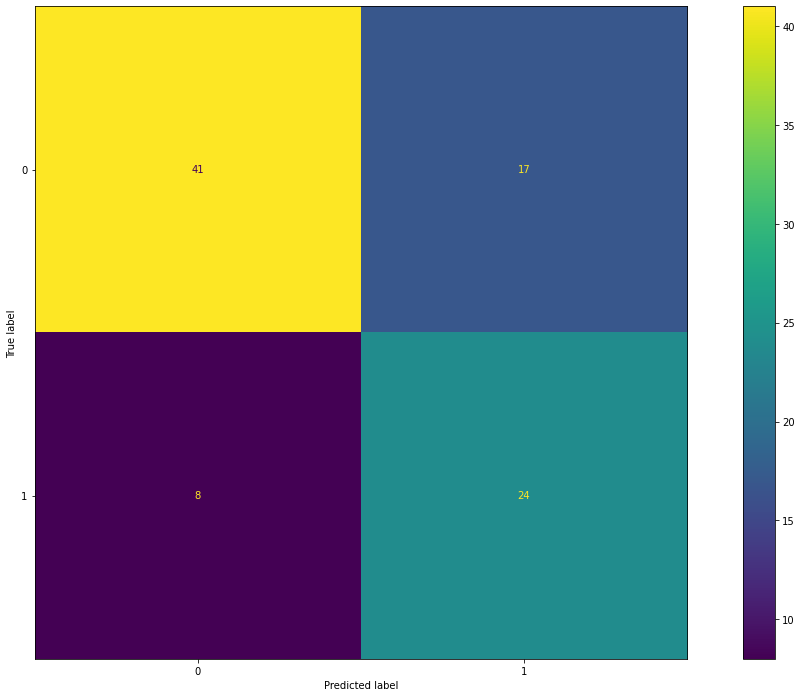

In [ ]:
cm = tree_cf(most_utf)